In [3]:
import sys
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, load_state_npz, MeasurementDataset, MeasurementLoader
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve, save_model
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction


data_dir = Path("measurements")
state_dir = Path("state_vectors")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")

Running on: cpu


In [6]:
SIDE_LENGTH = 3
FILE_SAMPLE_COUNT = 20_000
TRAIN_SAMPLE_COUNT = 20_000

h_support = [1.00, 1.40, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50]
h_novel = []
all_h_values = sorted(list(set(h_support + h_novel)))

file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

print(f"Support points: {h_support}")
print(f"Training on {TRAIN_SAMPLE_COUNT} samples per support point.")

samples_per_support = [TRAIN_SAMPLE_COUNT] * len(file_paths)
dataset = MeasurementDataset(file_paths, load_measurements_npz, ["h"], samples_per_support)

Support points: [1.0, 1.4, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
Training on 20000 samples per support point.


In [7]:
N_EPOCHS = 50
BATCH_SIZE = 1024
NUM_HIDDEN = 64
HYPER_NET_WIDTH = 64
K_STEPS = 20
GIBBS_NOISE_FRAC = 0.1
INIT_LR = 1e-2
FINAL_LR = 1e-4

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

loader = MeasurementLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, rng=rng)

model = SymmetricHyperRBM(num_v=dataset.num_qubits, num_h=NUM_HIDDEN, hyper_dim=HYPER_NET_WIDTH, k=K_STEPS).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=INIT_LR)
scheduler = get_sigmoid_curve(INIT_LR, FINAL_LR, N_EPOCHS*len(loader), 0.005)

model = train_loop(model, optimizer, loader, num_epochs=N_EPOCHS, lr_schedule_fn=scheduler, noise_frac=GIBBS_NOISE_FRAC, rng=rng)

Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0167     | 0.010000
10     | +0.0008     | 0.010000
20     | +0.0001     | 0.009881
30     | -0.0027     | 0.000221
40     | +0.0011     | 0.000100
50     | +0.0039     | 0.000100


h=1.00 (support) | Overlap = 0.99994
h=1.40 (support) | Overlap = 0.99985
h=1.50 (support) | Overlap = 0.99980
h=2.00 (support) | Overlap = 0.99939
h=2.50 (support) | Overlap = 0.99961
h=3.00 (support) | Overlap = 0.99976
h=3.50 (support) | Overlap = 0.99976
h=4.00 (support) | Overlap = 0.99982
h=4.50 (support) | Overlap = 0.99975


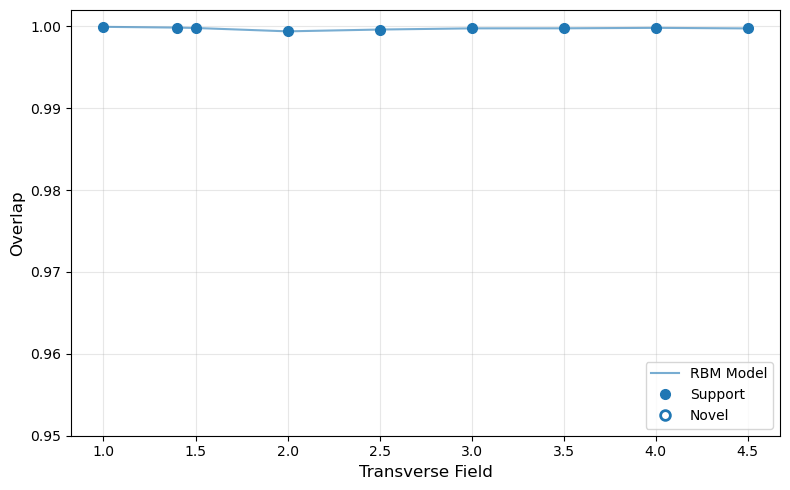

In [8]:
all_states = generate_basis_states(dataset.num_qubits, device)
h_support_arr = np.asarray(h_support)

overlap_rows = []
for h_val in all_h_values:
    gt_path = state_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h_val:.2f}.npz"
    psi_true = load_gt_wavefunction(gt_path, device)

    overlap = calculate_exact_overlap(model, h_val, psi_true, all_states)
    split = "support" if np.isclose(h_support_arr, h_val, atol=1e-3).any() else "novel"

    overlap_rows.append({"h": float(h_val), "overlap": float(overlap), "split": split})
    print(f"h={h_val:.2f} ({split:7}) | Overlap = {overlap:.5f}")

overlap_df = pd.DataFrame(overlap_rows)
support_df = overlap_df[overlap_df["split"] == "support"]
novel_df = overlap_df[overlap_df["split"] == "novel"]

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(overlap_df["h"], overlap_df["overlap"], '-', color='tab:blue', alpha=0.6, label="RBM Model")
plt.plot(support_df["h"], support_df["overlap"], 'o', color='tab:blue', markersize=7, label="Support")
plt.plot(novel_df["h"], novel_df["overlap"], 'o', color='tab:blue',
         markerfacecolor='white', markeredgewidth=2, markersize=7, label="Novel")
plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Overlap", fontsize=12)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [9]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"hyprbm_tfim_3x3_{TRAIN_SAMPLE_COUNT}_suscept_{timestamp}.pt"
save_path = models_dir / filename

config = { "train_samples": TRAIN_SAMPLE_COUNT, "epochs": N_EPOCHS, "h_support": h_support }
save_model(model, config, overlap_rows, save_path)

Model saved to: models/hyprbm_tfim_3x3_20000_suscept_20260203_200041.pt
